In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

import torch
import torch.nn as nn
import torch.optim as optim

# Set seed for reproducibility
torch.manual_seed(42)

In [2]:
PLUMED_EXE="plumed"

subprocess.run(f"{PLUMED_EXE}", shell=True)

def clean(folder='./'):
    subprocess.run("rm COLVAR KERNELS bck.* out* histogram* *log potential-coeffs.out.data stats.out", cwd=folder, shell=True)

Nothing to do. Use 'plumed help' for help


In [3]:
#muller-brown potential

def V(x,y):
    prefactor = 0.15
    A=(-200,-100,-170,15)
    a=(-1,-1,-6.5,0.7)
    b=(0,0,11,0.6)
    c=(-10,-10,-6.5,0.7)
    x0=(1,0,-0.5,-1)
    y0=(0,0.5,1.5,1)
    offset = -146.7

    v = -prefactor*offset
    for i in range(4):
        v += prefactor * A[i]*np.exp( a[i]*(x-x0[i])**2 + b[i]*(x-x0[i])*(y-y0[i]) + c[i]*(y-y0[i])**2 )
    return v

MULLER_BROWN_FORMULA='0.15*(146.7-200*exp(-1*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-100*exp(-1*(x-0)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

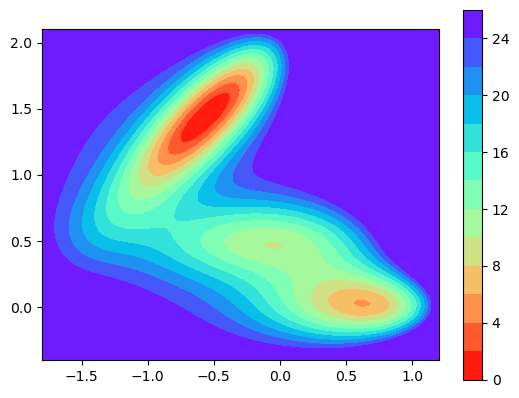

In [4]:
# Visualize
nx, ny = (100, 100)
xlims=(-1.8, 1.2)
ylims=(-0.4, 2.1)
x = np.linspace(xlims[0],xlims[1], nx)
y = np.linspace(ylims[0],ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = V(xv,yv)
max_pot = 26
pot[pot>max_pot] = max_pot # np.NaN

fig,ax = plt.subplots(dpi=100)
pp = ax.contourf(xv,yv,pot,16,cmap='rainbow_r')
ax.set_aspect('equal')
plt.colorbar(pp,ax=ax)
plt.show()

In [ ]:
folder = 'raw_data/Muller_Brown/'

Path(folder).mkdir(parents=True, exist_ok=True)

# md_potential for ves_md_linearexpansion (actual potential is in plumed.dat)
with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

# md_input for ves_md_linearexpansion
with open(folder+"md_input","w") as f:
    print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0.6,0
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=1.5 KAPPA=0.5

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=10
   BASIN_LL1=-0.7,1.4
   BASIN_UL1=-0.5,1.7 
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa05
""",file=f)

subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

In [ ]:
folder = 'raw_data/Muller_Brown/'

Path(folder).mkdir(parents=True, exist_ok=True)

# md_potential for ves_md_linearexpansion (actual potential is in plumed.dat)
with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

# md_input for ves_md_linearexpansion
with open(folder+"md_input","w") as f:
    print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0.6,0
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=1.5 KAPPA=1.25

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=10
   BASIN_LL1=-0.7,1.4
   BASIN_UL1=-0.5,1.7 
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa125
""",file=f)

subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

In [2]:
import plumed

folder = 'raw_data/Muller_Brown/'

#load 
colvar=plumed.read_as_pandas(folder+"COLVAR_ABMD_kappa05")
print(len(colvar))
colvar2 = plumed.read_as_pandas(folder+"COLVAR_ABMD_kappa125")
print(len(colvar2))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


2145911


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


1652341


/tmp/ipykernel_423577/1606235339.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  transition=torch.Tensor(transition)


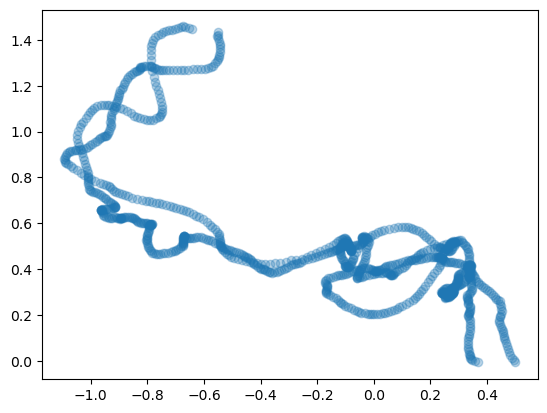

(1098, 2)

In [3]:
dynamics=np.array(colvar.iloc[:,:3],dtype=float)[::-1]

transition=[]
for t in dynamics:
    
    transition.append(t[1:])
        
    if t[2] < 0.0:
        break
transition=torch.Tensor(transition)

dynamics2=np.array(colvar2.iloc[:,:3],dtype=float)[::-1]

transition2=[]
for t in dynamics2:
    
    transition2.append(t[1:])
        
    if t[2] < 0.0:
        break      
transition2=torch.Tensor(transition2)

training_datapoints=np.vstack((transition,transition2))

plt.figure()
plt.scatter(training_datapoints[:,0], training_datapoints[:,1],alpha=0.3)
plt.show()

training_datapoints.shape

In [4]:
training_batches=[transition,transition2]

(500, 2)


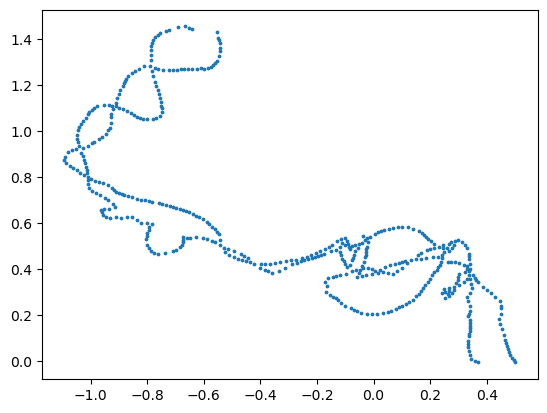

In [6]:
from skmatter.feature_selection import FPS

selector = FPS(n_to_select=500,initialize=0)

selector.fit(training_datapoints.T)
model_datapoints = selector.transform(training_datapoints.T).T

print(model_datapoints.shape)

plt.figure()
plt.scatter(model_datapoints[:,0],model_datapoints[:,1],s=3,alpha=1)
plt.show()

In [9]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        print('Numer of input features:',self.n_features)
        print('Numer of neighbors:',self.n_neighbors)
        print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers)
        print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers)
        print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-4) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
        
        x_w = x * (1 - y)
        x_w_softmax = self.softmax_w(x_w)
        y = y+x_w_softmax
            
        for k in range(self.n_neighbors):
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z)
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

In [10]:
training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)

ANN_architecture=[8]
AutoEncoder_architecture=[24,16]

n_features=2
d_metric=3
n_neighbors=3
l=50

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l)

device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=2, bias=True)
)


In [11]:
track=[]
best_loss=1e10

num_epochs = 5001
for epoch in range(num_epochs):
    train_loss = 0.0
    for data in training_batches:
        x = data
        
        # Forward Pass
        x_hat,s,d,dn = model.encode_decode(x)

        # Compute Loss
        loss = model.loss_mse(x_hat, x)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(training_batches)
    
    track.append(train_loss)
    
    if epoch%100==0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        
        if train_loss < best_loss:
            best_loss=train_loss
            filename = 'model.pth'
            torch.save(model, filename)   

Epoch: 1 	Training Loss: 195.376344
Epoch: 101 	Training Loss: 18.328588
Epoch: 201 	Training Loss: 10.769587
Epoch: 301 	Training Loss: 10.376535
Epoch: 401 	Training Loss: 10.130456
Epoch: 501 	Training Loss: 9.946792
Epoch: 601 	Training Loss: 9.731749
Epoch: 701 	Training Loss: 9.298347
Epoch: 801 	Training Loss: 7.781216
Epoch: 901 	Training Loss: 3.982251
Epoch: 1001 	Training Loss: 2.790456
Epoch: 1101 	Training Loss: 2.508933
Epoch: 1201 	Training Loss: 2.423865
Epoch: 1301 	Training Loss: 2.379848
Epoch: 1401 	Training Loss: 2.340280
Epoch: 1501 	Training Loss: 2.294537
Epoch: 1601 	Training Loss: 2.238470
Epoch: 1701 	Training Loss: 2.171763
Epoch: 1801 	Training Loss: 2.097609
Epoch: 1901 	Training Loss: 2.020746
Epoch: 2001 	Training Loss: 1.944480
Epoch: 2101 	Training Loss: 1.870401
Epoch: 2201 	Training Loss: 1.800288
Epoch: 2301 	Training Loss: 1.738742
Epoch: 2401 	Training Loss: 1.691452
Epoch: 2501 	Training Loss: 1.656216
Epoch: 2601 	Training Loss: 1.628549
Epoch: 

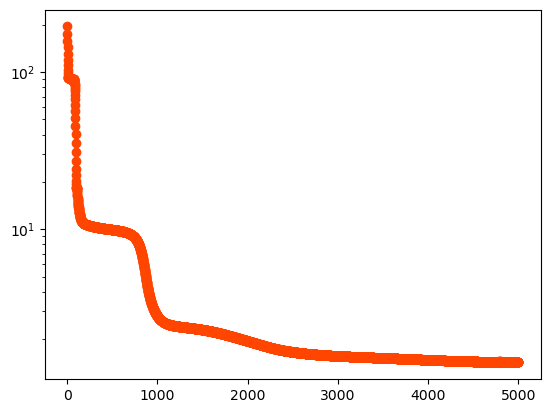

In [12]:
plt.figure()
plt.plot(track,'o-',color='orangered')
plt.yscale('log')
plt.show()

In [13]:
model_params=torch.save(model.state_dict(), 'model_params.pt')

In [14]:
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l)

plumed_model.load_state_dict(torch.load('model_params.pt'), strict=False)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=2, bias=True)
)


<All keys matched successfully>

In [15]:
m=torch.jit.trace(plumed_model,torch.ones(1,n_features))
m.save('model.ptc')

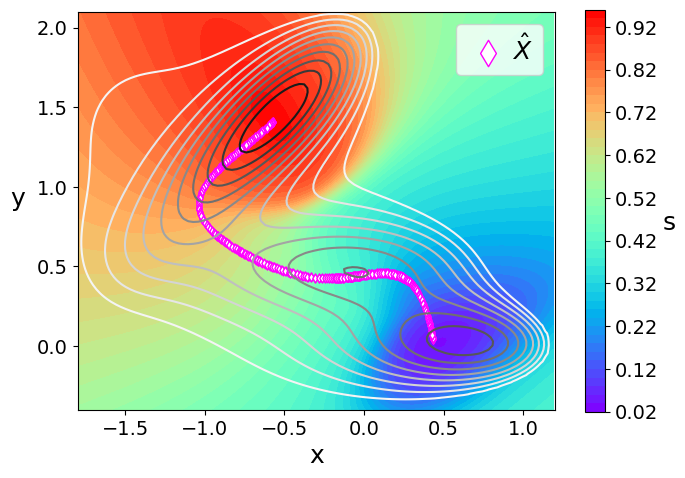

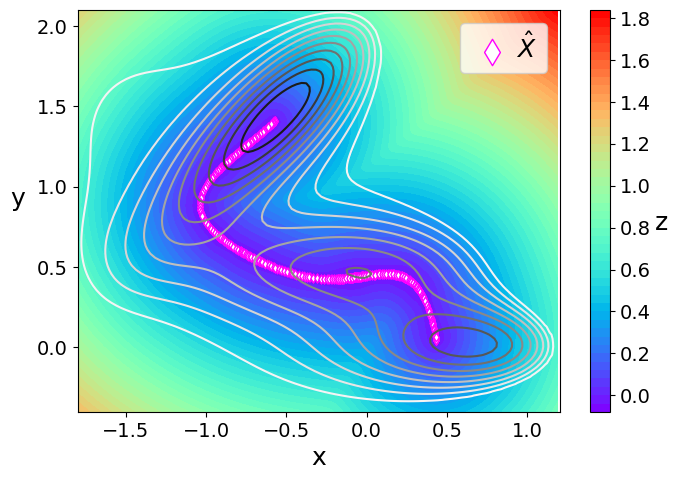

In [25]:
input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-1.8, 1.2, 0.01)
y_range = np.arange(-0.4, 2.1, 0.01)

# Create a grid of points
x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  


fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='magenta',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='magenta',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

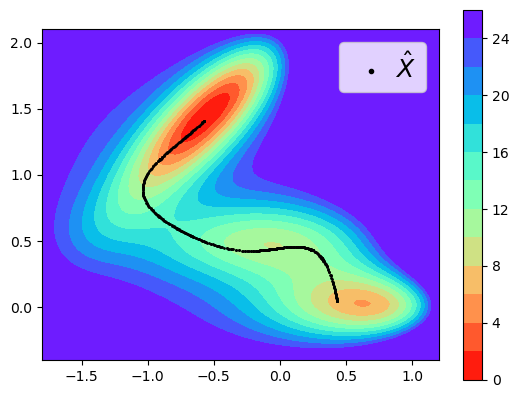

In [17]:
# Visualize X_hat of DeepLNE 
nx, ny = (100, 100)
xlims=(-1.8, 1.2)
ylims=(-0.4, 2.1)
x = np.linspace(xlims[0],xlims[1], nx)
y = np.linspace(ylims[0],ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = V(xv,yv)
max_pot = 26
pot[pot>max_pot] = max_pot # np.NaN

fig,ax = plt.subplots(dpi=100)
pp = ax.contourf(xv,yv,pot,16,cmap='rainbow_r')
ax.set_aspect('equal')
plt.colorbar(pp,ax=ax)
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=1,label=r'$\hat{X}$')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.show()

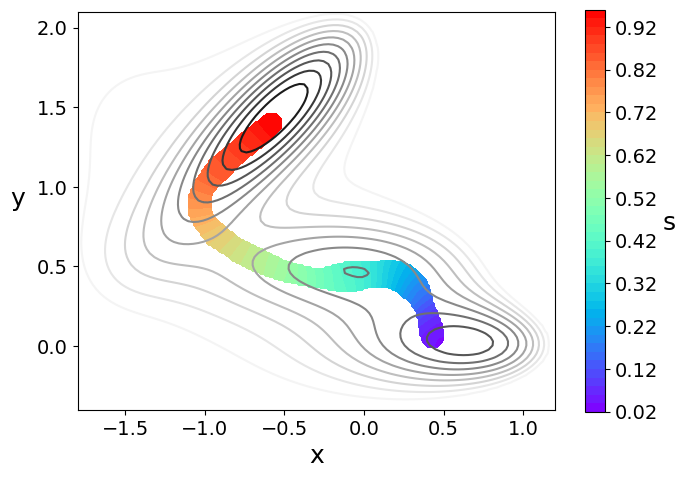

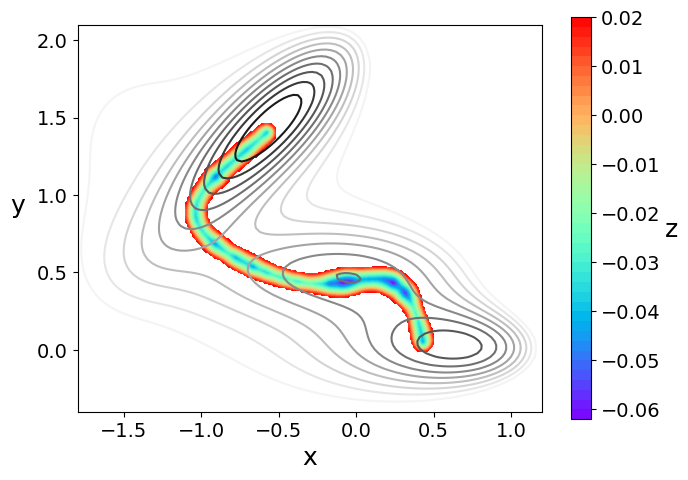

In [19]:
#in order to decide which UWALL might be applied for z, or model.node-1 in plumed.dat

choose_z_threshold=0.02

input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-1.8, 1.2, 0.01)
y_range = np.arange(-0.4, 2.1, 0.01)

# Create a grid of points
x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  


condition = (grid_z < choose_z_threshold)
filtered_grid_s = np.where(condition, grid_s, np.nan)
filtered_grid_z = np.where(condition, grid_z, np.nan)


fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,filtered_grid_s,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,filtered_grid_z,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [23]:
folder = 'raw_data/Muller_Brown/'

In [ ]:
!scp model.ptc raw_data/Muller_Brown

In [ ]:
# md_potential for ves_md_linearexpansion (actual potential is in plumed.dat)
with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

# md_input for ves_md_linearexpansion
with open(folder+"md_input","w") as f:
    print("""
nstep                   2000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        -0.75,1.5
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

model: PYTORCH_MODEL FILE=model.ptc ARG=p.x,p.y

#opes: OPES_METAD ARG=p.y BARRIER=10 PACE=200
opes: OPES_METAD ARG=model.node-0 BARRIER=10 PACE=200

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
uwall2: UPPER_WALLS ARG=model.node-1 KAPPA=1000 AT=+0.02

PRINT STRIDE=200 ARG=* FILE=COLVAR_DeepLNE
""",file=f)

10001


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


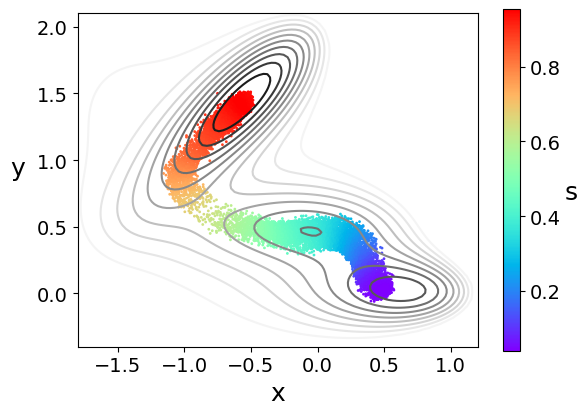

In [24]:
#load 
colvar = plumed.read_as_pandas(folder+"COLVAR_DeepLNE")
print(len(colvar))

# plot pot isolines + samples
fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model.node-0'],cmap='rainbow',s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()